In [1]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('dataset_janelas_5_seg.csv')

## Separando o dataset de treino e teste
 * Dados do mesmo paciente não podem ficar em amostras separadas, ou seja, não posso ter dado do mesmo paciente na amostra de treino e na amostra de validação.
 * Como temos 551 pacientes, foi separado 20% desses pacientes para teste, gerando o total de 110 pacientes para teste, sendo 55 com SVT e 55 normais

In [3]:
porcentagem_pacientes = int(df['patient'].nunique()*0.2/2)

In [4]:
patient_SVT = df[df['classes']==1]['patient'].sample(porcentagem_pacientes).unique()

In [5]:
patient_normal = df[df['classes']==0]['patient'].sample(porcentagem_pacientes).unique()

In [6]:
amostra_teste = list(patient_SVT) + list(patient_normal)

In [7]:
df.head(3)

patient  num_janela  RR_media  RS_media  QR_media  \
0  MUSE_20180111_155633_99000           1  0.014781  0.044256  0.042571   
1  MUSE_20180111_155633_99000           2  0.018165  0.034188  0.036119   
2  MUSE_20180111_160708_00000           1  0.007057  0.037137  0.032032   

   R_media_amplitude  Q_media_amplitude  classes  
0           0.151099           0.113279        1  
1           0.136143           0.072974        1  
2           0.697362           0.296293        1

In [8]:
X_train = df[~df['patient'].isin(amostra_teste)]

In [9]:
y_train = X_train['classes'].values

In [10]:
X_test = df[df['patient'].isin(amostra_teste)]

In [11]:
y_test = X_test['classes'].values

In [12]:
print(len(X_train), len(X_test))

888 214


In [13]:
X_train = X_train.drop(columns=['patient', 'classes', 'num_janela'])

In [14]:
X_train.head()

RR_media  RS_media  QR_media  R_media_amplitude  Q_media_amplitude
0  0.014781  0.044256  0.042571           0.151099           0.113279
1  0.018165  0.034188  0.036119           0.136143           0.072974
2  0.007057  0.037137  0.032032           0.697362           0.296293
3  0.009010  0.030817  0.028024           0.167592           0.175770
4  0.004364  0.013108  0.011417           0.002440           0.005619

In [15]:
X_test = X_test.drop(columns=['patient', 'classes', 'num_janela'])

In [16]:
X_test.head()

RR_media  RS_media  QR_media  R_media_amplitude  Q_media_amplitude
12  0.003827  0.008388  0.008732           0.016705           0.015453
13  0.002768  0.008570  0.009366           0.012388           0.017080
20  0.012688  0.053216  0.054707           0.244488           0.236788
21  0.013608  0.048136  0.044413           0.016646           0.015074
22  0.014271  0.046244  0.040994           0.241885           0.337316

# Grid Search

In [17]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.5, 1],
    'max_depth': [1, 2, 3, 4, 5],
    'n_estimators': [100, 200, 300, 400]
}

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
xgb_model = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy',cv=cv)

In [20]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_typ...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.5, 1],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='accuracy')

In [21]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [22]:
best_model = grid_search.best_estimator_

In [23]:
best_params

{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}

In [24]:
preds = best_model.predict(X_test)

In [25]:
print(classification_report(preds, y_test))

              precision    recall  f1-score   support

           0       0.75      0.71      0.73       112
           1       0.70      0.75      0.72       102

    accuracy                           0.73       214
   macro avg       0.73      0.73      0.73       214
weighted avg       0.73      0.73      0.73       214



<BarContainer object of 5 artists>

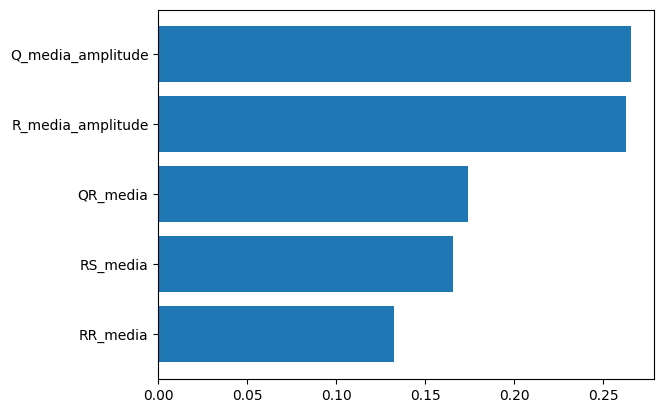

In [26]:
plt.barh(X_train.columns, best_model.feature_importances_)